<a href="https://colab.research.google.com/github/18521564/CS114.K21/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---------------Giới thiệu vấn đề--------------

VGG16 CHO CIFAR-10:

1.Mô tả bộ dữ liệu:
Gồm 60000 ảnh 32x32 3 kênh màu RGB chia thành  10 classes. Mỗi class gồm 6000 ảnh. Nguồn : "https://www.cs.toronto.edu/~kriz/cifar.html"
10 classes bao gồm, theo thứ tự:
0. máy bay airplane
1. xe hơi automobile
2. chim bird
3. mèo cat
4. hươu deer
5. chó dog
6. ếch frog
7. ngựa horse
8. tàu(hàng thủy) ship
9. xe tải truck

2.Bài toán:
Đưa vào một tấm ảnh mà model chưa gặp và có thể phân loại nó vào 1 trong 10 classes trên.


Phần 1: Cài đặt các thông số cố định và tải bộ dữ liệu:
Để thư viện và thông số cố định trong một phần riêng để dễ dàng cho việc chỉnh sửa sau này.


In [ ]:
#import thư viện
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from keras.callbacks import ModelCheckpoint

#thông số ảnh của bộ dữ liệu:
IMG_CHANNELS = 3 #số kênh màu
IMG_ROWS = 32 #chiều ngang
IMG_COLS = 32 #chiều dọc
#các thông số sử dụng sau này:
BATCH_SIZE = 64 #số lượng dữ liệu trong một mini-batch
EPOCHS = 50 #số lần lặp lại training với cùng dữ liệu train
NUM_CLASSES = 10 #số classes đầu ra
VERBOSE = 1 #cách hiển thị để theo dõi quá trình training 
OPTIM = tf.keras.optimizers.RMSprop() #thuật toán tối ưu lặp lại, ở đây ta dùng RMSprop 


Phần 2: Tải và tiền xử lý data
+ Sử dụng mean và standard deviation của tập train để chuẩn hóa cả tập train và test
+ dùng to_categorical để xử lý label

In [ ]:
#hàm tải data bao gồm việc chuẩn hóa và xử lý to_categorical với các label
def load_data():
 (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
 #show ảnh thử:
 num_row = 3
 num_col = 5

 fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
 fig.suptitle("15 ảnh minh họa", fontsize=16)
 for i in range(num_row * num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X_train[i], cmap='gray')
 plt.tight_layout()
 plt.show()

 x_train = x_train.astype('float32')
 x_test = x_test.astype('float32')
 # normalize: chuẩn hóa bằng mean và standard deviation của tập train, tập test sử dụng mean và std từ tập train
 mean = np.mean(x_train,axis=(0,1,2,3))
 std = np.std(x_train,axis=(0,1,2,3))
 x_train = (x_train-mean)/(std+1e-7)
 x_test = (x_test-mean)/(std+1e-7)
 y_train = tf.keras.utils.to_categorical(y_train,NUM_CLASSES)
 y_test = tf.keras.utils.to_categorical(y_test,NUM_CLASSES)
 return x_train, y_train, x_test, y_test


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

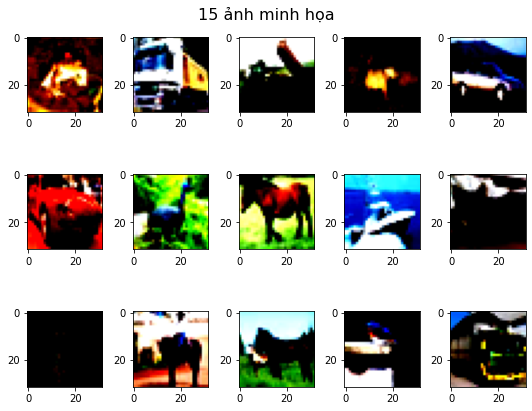

In [ ]:
#lấy data:
(X_train, y_train, X_test, y_test) = load_data()

Phần 2: 

2.1 Xây dựng model
+ Model đơn giản:
với 3 block VGG. Mỗi block gồm 2 convolutional layers với filter (3x3) và một max pooling (2x2). Số lượng filter tăng dần từ 32, 64, 128.

2.2 Kỹ thuật Regurlazation giảm overfitting:
+ Batch normalization: chuẩn hóa output với mean = 0 và std = 1.
+ Dropping: ngẫu nhiên loại bỏ bớt node trong các lớp, với tỉ lệ khác nhau và tăng dần. 
+ Data augmentation: tạo data mới từ data cũ bằng cách xoay, di chuyển, vvv.

2.3 Chuẩn bị model:
+ loss function: categorical_crossentropy
+ thuật toán tối ưu: RMSprop


In [ ]:
#hàm cài đặt model, dùng hàm thuận tiện cho việc sửa đổi và tái sử dụng
def basic_VGG_model(INPUT_SHAPE,CLASSES):
    model = models.Sequential()
    
    #1st blocl
    model.add(layers.Conv2D(32, (3,3), padding='same', 
        input_shape=INPUT_SHAPE, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.2))

    #2nd block
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))

    #3d block 
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.4))

    #dense  
    model.add(layers.Flatten())
    model.add(layers.Dense(CLASSES, activation='softmax'))
    return model

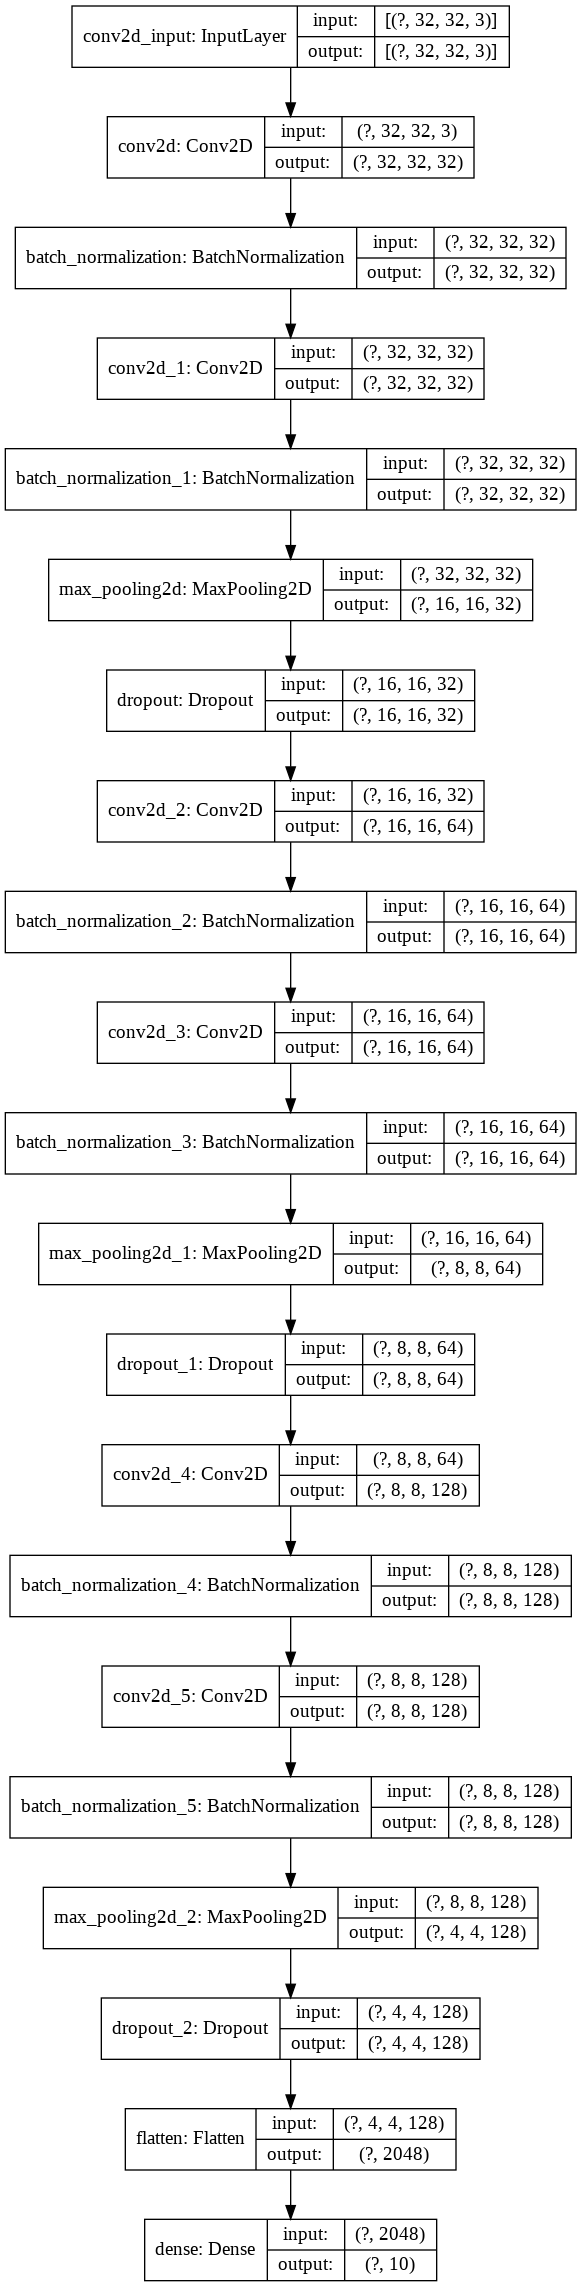

In [ ]:
#Tạo model từ hàm:
model = basic_VGG_model((IMG_ROWS, IMG_COLS, IMG_CHANNELS), NUM_CLASSES)
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [ ]:
# compiling model:
model.compile(loss='categorical_crossentropy', optimizer=OPTIM,
	metrics=['accuracy'])

Phần 3: Training

Ta có tập train, test và tập validation
+ train : 50000
+ test : 10000
+ validation: 20%

Sử dụng kỹ thuật data augmentation.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#image augmentation
datagen = ImageDataGenerator(
 rotation_range=30,
 width_shift_range=0.2,
 height_shift_range=0.2,
 horizontal_flip=True,
 )
datagen.fit(X_train)

#con trỏ:
iterator = datagen.flow(X_train, y_train,
 batch_size=BATCH_SIZE)

In [ ]:
#tạo checkpoint lưu model:
checkpoint_path = "/content/drive/My Drive/doAn/my_first_model.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
#training:
model.fit_generator(iterator,
 epochs=EPOCHS,
 verbose=1,validation_data=(X_test,y_test),callbacks = [cp_callback])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
782/782 [==============================] - ETA: 0s - loss: 2.0931 - accuracy: 0.3631
Epoch 00001: saving model to /content/drive/My Drive/doAn/my_first_model.ckpt
782/782 [==============================] - 446s 571ms/step - loss: 2.0931 - accuracy: 0.3631 - val_loss: 1.7140 - val_accuracy: 0.4619
Epoch 2/50
782/782 [==============================] - ETA: 0s - loss: 1.5633 - accuracy: 0.4955
Epoch 00002: saving model to /content/drive/My Drive/doAn/my_first_model.ckpt
782/782 [==============================] - 454s 581ms/step - loss: 1.5633 - accuracy: 0.4955 - val_loss: 1.3906 - val_accuracy: 0.5656
Epoch 3/50
782/782 [==============================] - ETA: 0s - loss: 1.3597 - accuracy: 0.5593
Epoch 00003: saving model to /content/drive/My Drive/doAn/my_first_model.ckpt
782/782 [==============================] - 457s 584ms/step - loss: 1.3597 - accuracy: 0.5593 - val_loss: 1.3035 - val_accuracy: 0.59

In [ ]:
#lưu model ở dạng json
#lưu weight ở dạng h5
model_json = model.to_json()
with open('model.json', 'w') as json_file:
 json_file.write(model_json)
model.save_weights('model.h5') 

In [ ]:
import numpy as np
#import scipy.misc

from skimage.transform import resize
from imageio import imread

from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import SGD

In [ ]:
#tái sử dụng lại model:
model_architecture = "/content/drive/My Drive/doAn/Do_an_real/model.json"
model_weights = "/content/drive/My Drive/doAn/Do_an_real/model.h5"
model = model_from_json(open(model_architecture).read())
model.load_weights(model_weights)

#tái compile:
optim = SGD()
model.compile(loss="categorical_crossentropy", optimizer=optim, metrics=["accuracy"])

In [ ]:
scores = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0])) 

79/79 [==============================] - 18s 223ms/step - loss: 0.4660 - accuracy: 0.8502

Test result: 85.020 loss: 0.466


In [ ]:
import numpy as np
#import scipy.misc

from skimage.transform import resize
from imageio import imread

from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import SGD

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


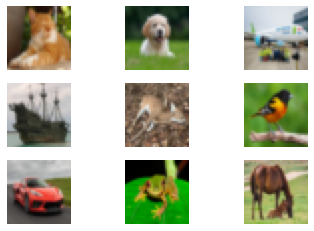

In [ ]:
img_names = ["/content/drive/My Drive/doAn/Do_an_real/meo.jpg",
             "/content/drive/My Drive/doAn/Do_an_real/dog.jpg",
             "/content/drive/My Drive/doAn/Do_an_real/bamboo.jpg"
             ,"/content/drive/My Drive/doAn/Do_an_real/caribean_pirate.jpg",
             "/content/drive/My Drive/doAn/Do_an_real/deer.jpg",
             "/content/drive/My Drive/doAn/Do_an_real/_108857562_mediaitem108857561.jpg",
             "/content/drive/My Drive/doAn/Do_an_real/car.jpg",
             "/content/drive/My Drive/doAn/Do_an_real/tải xuống (4).jpg",
             "/content/drive/My Drive/doAn/Do_an_real/tải xuống (5).jpg"
             ]
imgs = [resize(imread(img_name), (32, 32)).astype("float32") for img_name in img_names]
mean = np.mean(X_train,axis=(0,1,2,3))
std = np.std(X_train,axis=(0,1,2,3))
imgs = (imgs-mean)/(std+1e-7)

fig, ax = plt.subplots(3, 3)
for i, axi in enumerate(ax.flat):
    axi.imshow(imgs[i], cmap='gray')
    axi.axis('off')


In [ ]:
predictions = model.predict_classes(imgs)
print("predictions:", predictions)
#sai 3 tấm cuối cùng

predictions: [3 5 0 8 4 2 0 4 4]


In [ ]:
import numpy as np
import scipy.misc
from keras.models import model_from_json
from tensorflow import keras
from keras.optimizers import SGD